# 1. Importing Required Libraries

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import butter, filtfilt


# 2. Helper Functions for Generating IMU Columns
   

Function for 3-Axis IMU Sensors

In [20]:
def generate_three_IMU(name):
    x = name + '_x'
    y = name + '_y'
    z = name + '_z'
    return [x, y, z]


Function for 4-Axis IMU Sensors (Orientation)

In [21]:
def generate_four_IMU(name):
    x = name + '_x'
    y = name + '_y'
    z = name + '_z'
    w = name + '_w'
    return [x, y, z, w]


# 3. Function to Generate All IMU Columns for a Sensor

In [22]:
def generate_cols_IMU(name):
    output = [name + '_temperature']  # temperature
    output.extend(generate_three_IMU(name + '_3D_acceleration_16'))  # acceleration 16
    output.extend(generate_three_IMU(name + '_3D_acceleration_6'))  # acceleration 6
    output.extend(generate_three_IMU(name + '_3D_gyroscope'))  # gyroscope
    output.extend(generate_three_IMU(name + '_3D_magnetometer'))  # magnetometer
    output.extend(generate_four_IMU(name + '_4D_orientation'))  # orientation
    return output


# 4. Load IMU Data from Hand, Chest, and Ankle Sensors

In [23]:
def load_IMU():
    output = ['time_stamp', 'activity_id', 'heart_rate']  # common columns
    output.extend(generate_cols_IMU('hand'))  # IMU sensors for hand
    output.extend(generate_cols_IMU('chest'))  # IMU sensors for chest
    output.extend(generate_cols_IMU('ankle'))  # IMU sensors for ankle
    return output


# 5. Loading Dataset for Subjects 101 to 109

In [24]:
def load_subjects(root='/Users/rishav/Downloads/pamap2+physical+activity+monitoring/PAMAP2_Dataset/Protocol/subject'):
    output = pd.DataFrame()  # initialize an empty DataFrame
    cols = load_IMU()  # load column names
    
    for i in range(101, 110):  # loop through subject files 101 to 109
        path = root + str(i) + '.dat'  # file path for each subject
        subject = pd.read_table(path, header=None, sep='\s+')  # load subject data
        subject.columns = cols  # assign column names
        subject['id'] = i  # assign subject ID
        output = pd.concat([output, subject], ignore_index=True)  # append to the output DataFrame
    
    output.reset_index(drop=True, inplace=True)  # reset the index
    return output


<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/var/folders/ww/qjh9zpks52d4vsjxc4bg379h0000gn/T/ipykernel_23005/404901811.py:7: SyntaxWarning: invalid escape sequence '\s'
  subject = pd.read_table(path, header=None, sep='\s+')  # load subject data


# 6. Resampling and Time-Based Interpolation

In [25]:
def resample_and_time_interpolate(data, frequency='10ms'):
    # Convert 'time_stamp' to datetime if not already
    data['time_stamp'] = pd.to_datetime(data['time_stamp'])
    
    # Set 'time_stamp' as the index for resampling
    data.set_index('time_stamp', inplace=True)
    
    # Resample the data to the desired frequency (100 Hz = 10 ms)
    resampled_data = data.resample(frequency).mean()  # average for resampling
    
    # Reindex to original timestamps to keep the same shape
    resampled_data = resampled_data.reindex(data.index, method='ffill')
    
    # Interpolate missing values based on time intervals
    time_interpolated_data = resampled_data.interpolate(method='time')
    
    # Reset index to restore 'time_stamp' as a column
    time_interpolated_data.reset_index(inplace=True)
    
    return time_interpolated_data


# 7. Filtering the Dataset by Activity IDs

In [26]:
def filter_activities(data):
    return data[data['activity_id'].isin([1, 2, 3, 4])]

# 8. Butterworth Low-Pass Filter

In [27]:
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
def apply_lowpass_filter(data, cutoff=10, fs=100.0, order=5):
    # Design the Butterworth low-pass filter
    b, a = butter_lowpass(cutoff, fs, order=order)
    
    # Apply the filter to each IMU column (excluding non-numeric columns)
    filtered_data = data.copy()
    imu_columns = data.columns.difference(['time_stamp', 'activity_id', 'heart_rate', 'id'])

    for column in imu_columns:
        filtered_data[column] = filtfilt(b, a, data[column])
    
    return filtered_data



# 9. Data Normalization using Min-Max Scaling

In [28]:
def normalize_data(data):
    scaler = MinMaxScaler()
    imu_columns = data.columns.difference(['time_stamp', 'activity_id', 'heart_rate', 'id'])
    
    data[imu_columns] = scaler.fit_transform(data[imu_columns])
    
    return data

# 10. Covariance Similarity Matrix Calculation

In [29]:
def calculate_covariance_matrix(data):
    # Select only the IMU columns for covariance calculation
    imu_columns = data.columns.difference(['time_stamp', 'activity_id', 'heart_rate', 'id'])
    
    # Calculate the covariance matrix for the IMU columns
    covariance_matrix = data[imu_columns].cov()
    
    return covariance_matrix


# 11. Loading, Processing, and Plotting Data

In [30]:
data = load_subjects()
filtered_data = filter_activities(data)
resampled_data = resample_and_time_interpolate(filtered_data)
filtered_resampled_data = apply_lowpass_filter(resampled_data, cutoff=10, fs=100.0)
normalized_data = normalize_data(filtered_resampled_data)


/var/folders/ww/qjh9zpks52d4vsjxc4bg379h0000gn/T/ipykernel_23005/4265643362.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_stamp'] = pd.to_datetime(data['time_stamp'])


Covariance Matrix Calculation and Plotting

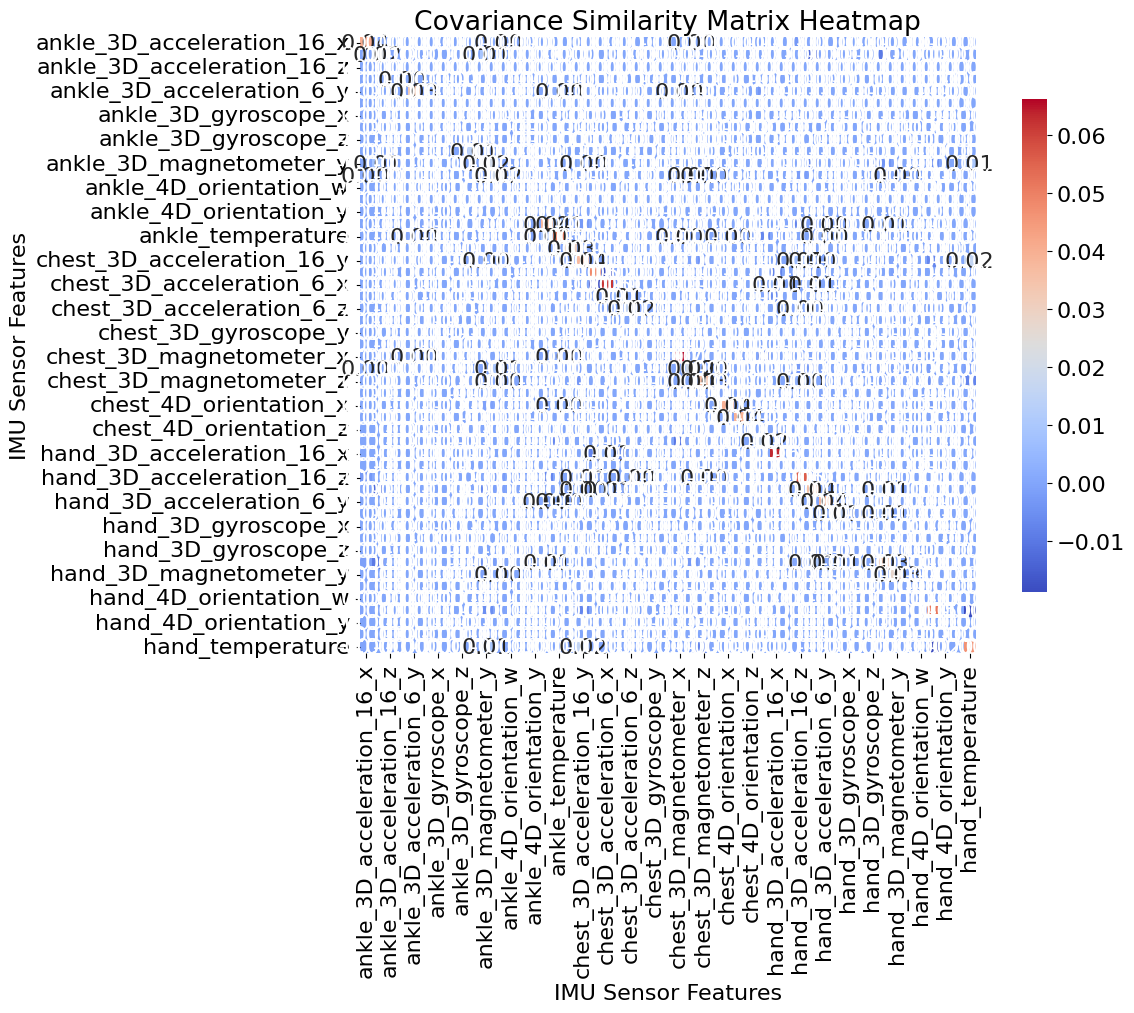

In [31]:
covariance_matrix = calculate_covariance_matrix(normalized_data)

# Plotting the covariance matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(covariance_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Covariance Similarity Matrix Heatmap')
plt.xlabel('IMU Sensor Features')
plt.ylabel('IMU Sensor Features')
plt.show()


# 12. Additional Analysis and Plotting

Descriptive Statistics

In [36]:
map_ac = {
    1: 'Walking',
    2: 'Jogging',
    3: 'Sitting',
    4: 'Standing',
}
print('Size of the data: ', data.size)
print('Shape of the data: ', data.shape)
print('Number of columns in the data: ', len(data.columns))
result_id = filtered_data.groupby(['id']).mean().reset_index()
result_act = filtered_data.groupby(['activity_id']).mean().reset_index()
def pd_fast_plot(pd_df, column_a, column_b, title, figsize=(10, 6)):
    plt.rcParams.update({'font.size': 16})
    size = range(len(pd_df))
    f, ax = plt.subplots(figsize=figsize) 
    plt.bar(size, pd_df[column_a], color=plt.cm.Paired(size))
    ax.set_xticks(size)
    ax.set_xticklabels(pd_df[column_b], rotation=45)
    ax.set_title(title)
    plt.show()
print(data.columns)

Size of the data:  157989315
Shape of the data:  (2872533, 55)
Number of columns in the data:  55
Index(['time_stamp', 'activity_id', 'heart_rate', 'hand_temperature',
       'hand_3D_acceleration_16_x', 'hand_3D_acceleration_16_y',
       'hand_3D_acceleration_16_z', 'hand_3D_acceleration_6_x',
       'hand_3D_acceleration_6_y', 'hand_3D_acceleration_6_z',
       'hand_3D_gyroscope_x', 'hand_3D_gyroscope_y', 'hand_3D_gyroscope_z',
       'hand_3D_magnetometer_x', 'hand_3D_magnetometer_y',
       'hand_3D_magnetometer_z', 'hand_4D_orientation_x',
       'hand_4D_orientation_y', 'hand_4D_orientation_z',
       'hand_4D_orientation_w', 'chest_temperature',
       'chest_3D_acceleration_16_x', 'chest_3D_acceleration_16_y',
       'chest_3D_acceleration_16_z', 'chest_3D_acceleration_6_x',
       'chest_3D_acceleration_6_y', 'chest_3D_acceleration_6_z',
       'chest_3D_gyroscope_x', 'chest_3D_gyroscope_y', 'chest_3D_gyroscope_z',
       'chest_3D_magnetometer_x', 'chest_3D_magnetometer_y',

 Plotting samples count by user ID(for required 4 classes)


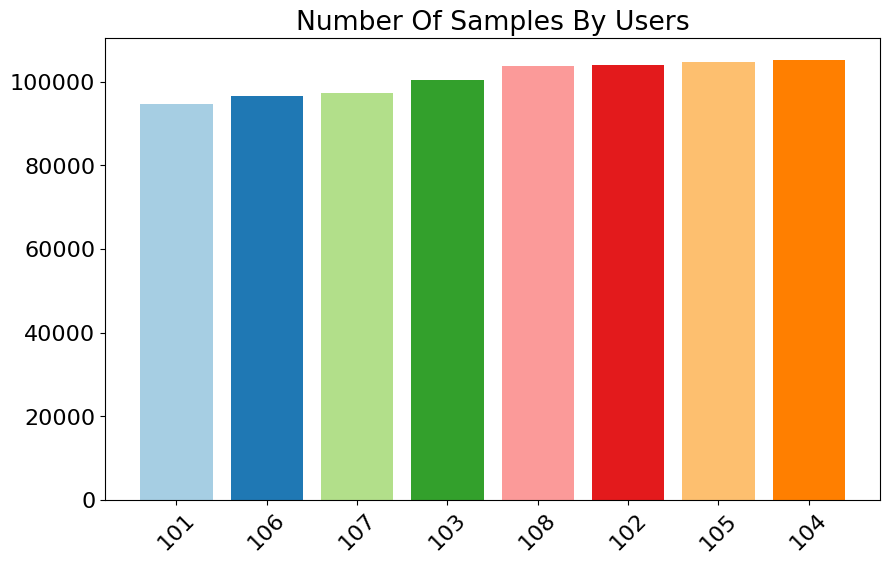

In [37]:
def pd_fast_plot(pd_df, column_a, column_b, title, figsize=(10, 6)):
    plt.rcParams.update({'font.size': 16})
    size = range(len(pd_df))
    f, ax = plt.subplots(figsize=figsize) 
    plt.bar(size, pd_df[column_a], color=plt.cm.Paired(size))
    ax.set_xticks(size)
    ax.set_xticklabels(pd_df[column_b], rotation=45)
    ax.set_title(title)
    plt.show()
samples =filtered_data.groupby(['id']).count().reset_index()
samples_to_subject = pd.DataFrame()
samples_to_subject['id'] = samples['id']
samples_to_subject['samples'] = samples['activity_id']
samples_to_subject = samples_to_subject.sort_values(by=['samples'])
pd_fast_plot(samples_to_subject, 'samples', 'id', 'Number Of Samples By Users')


Plotting samples count by activity

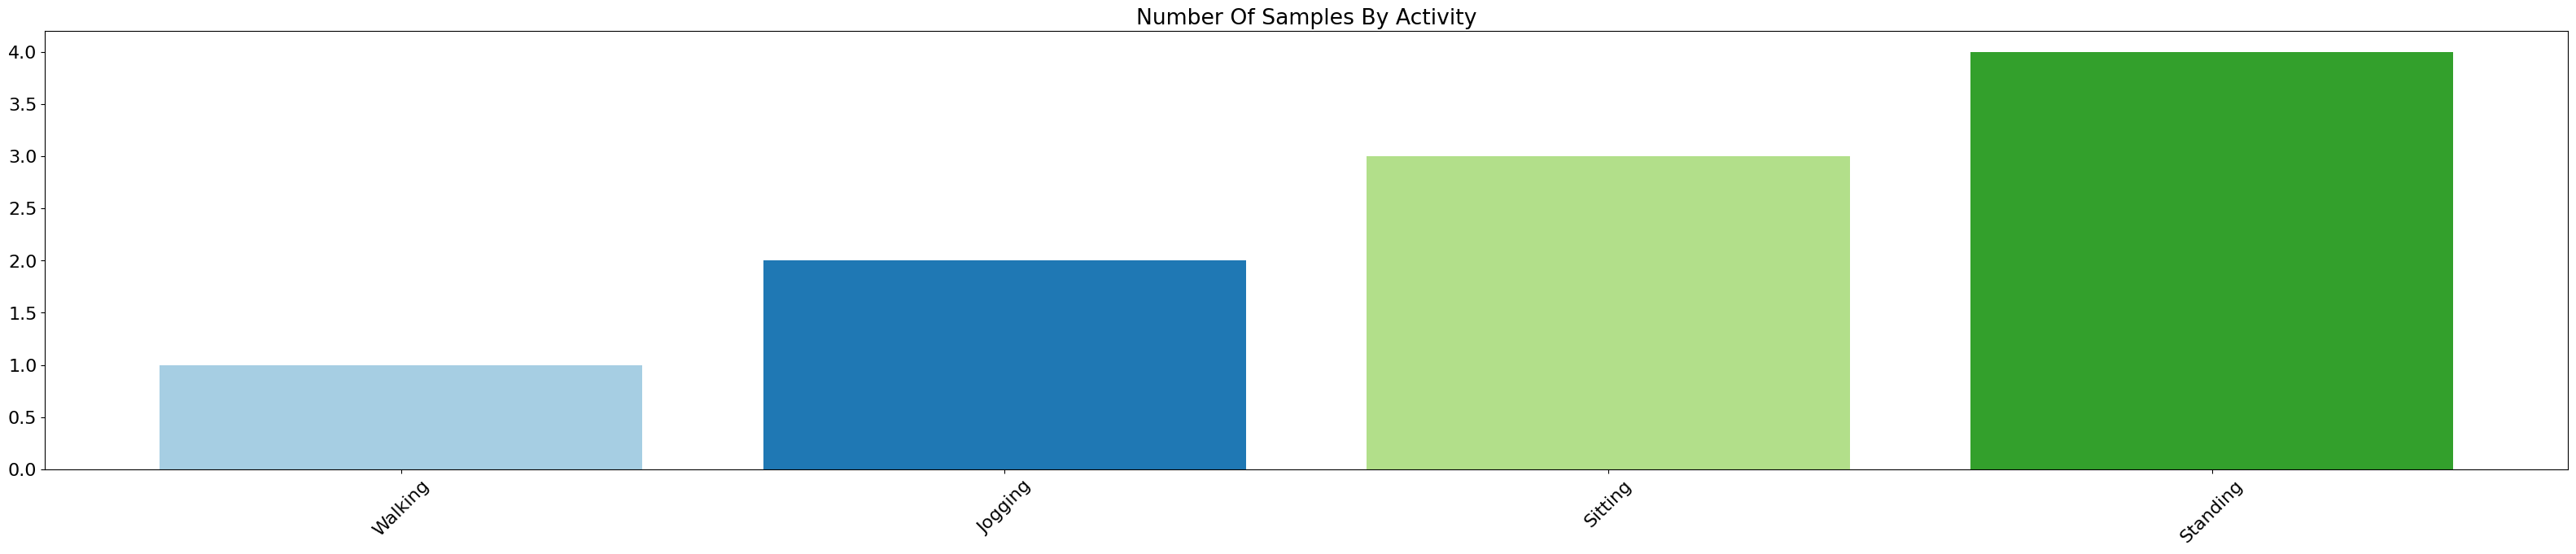

In [38]:

samples_activity = filtered_data.groupby(['activity_id']).count().reset_index()
samples_to_subject_activity = pd.DataFrame()
samples_to_subject_activity['activity'] = [map_ac[x] for x in samples_activity['activity_id']]
samples_to_subject_activity['samples'] = samples_activity['activity_id']
samples_to_subject_activity = samples_to_subject_activity.sort_values(by=['samples'])
pd_fast_plot(samples_to_subject_activity, 'samples', 'activity', 'Number Of Samples By Activity', figsize=(40, 7))


Average heart rate by subject

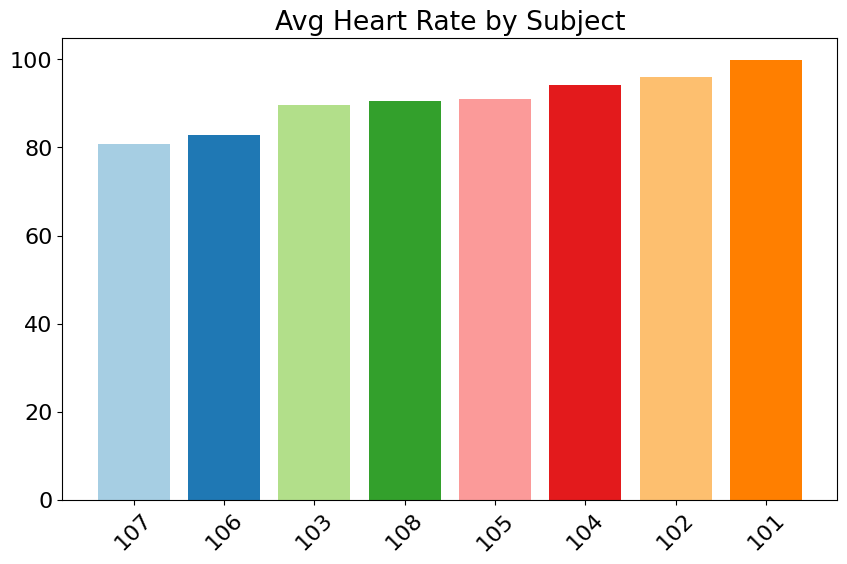

In [39]:

samples_heart_rate = pd.DataFrame()
samples_heart_rate['id'] = result_id['id']
samples_heart_rate['heart_rate'] = result_id['heart_rate']
samples_heart_rate = samples_heart_rate.sort_values(by=['heart_rate'])
pd_fast_plot(samples_heart_rate, 'heart_rate', 'id', 'Avg Heart Rate by Subject')


Average heart rate by activity

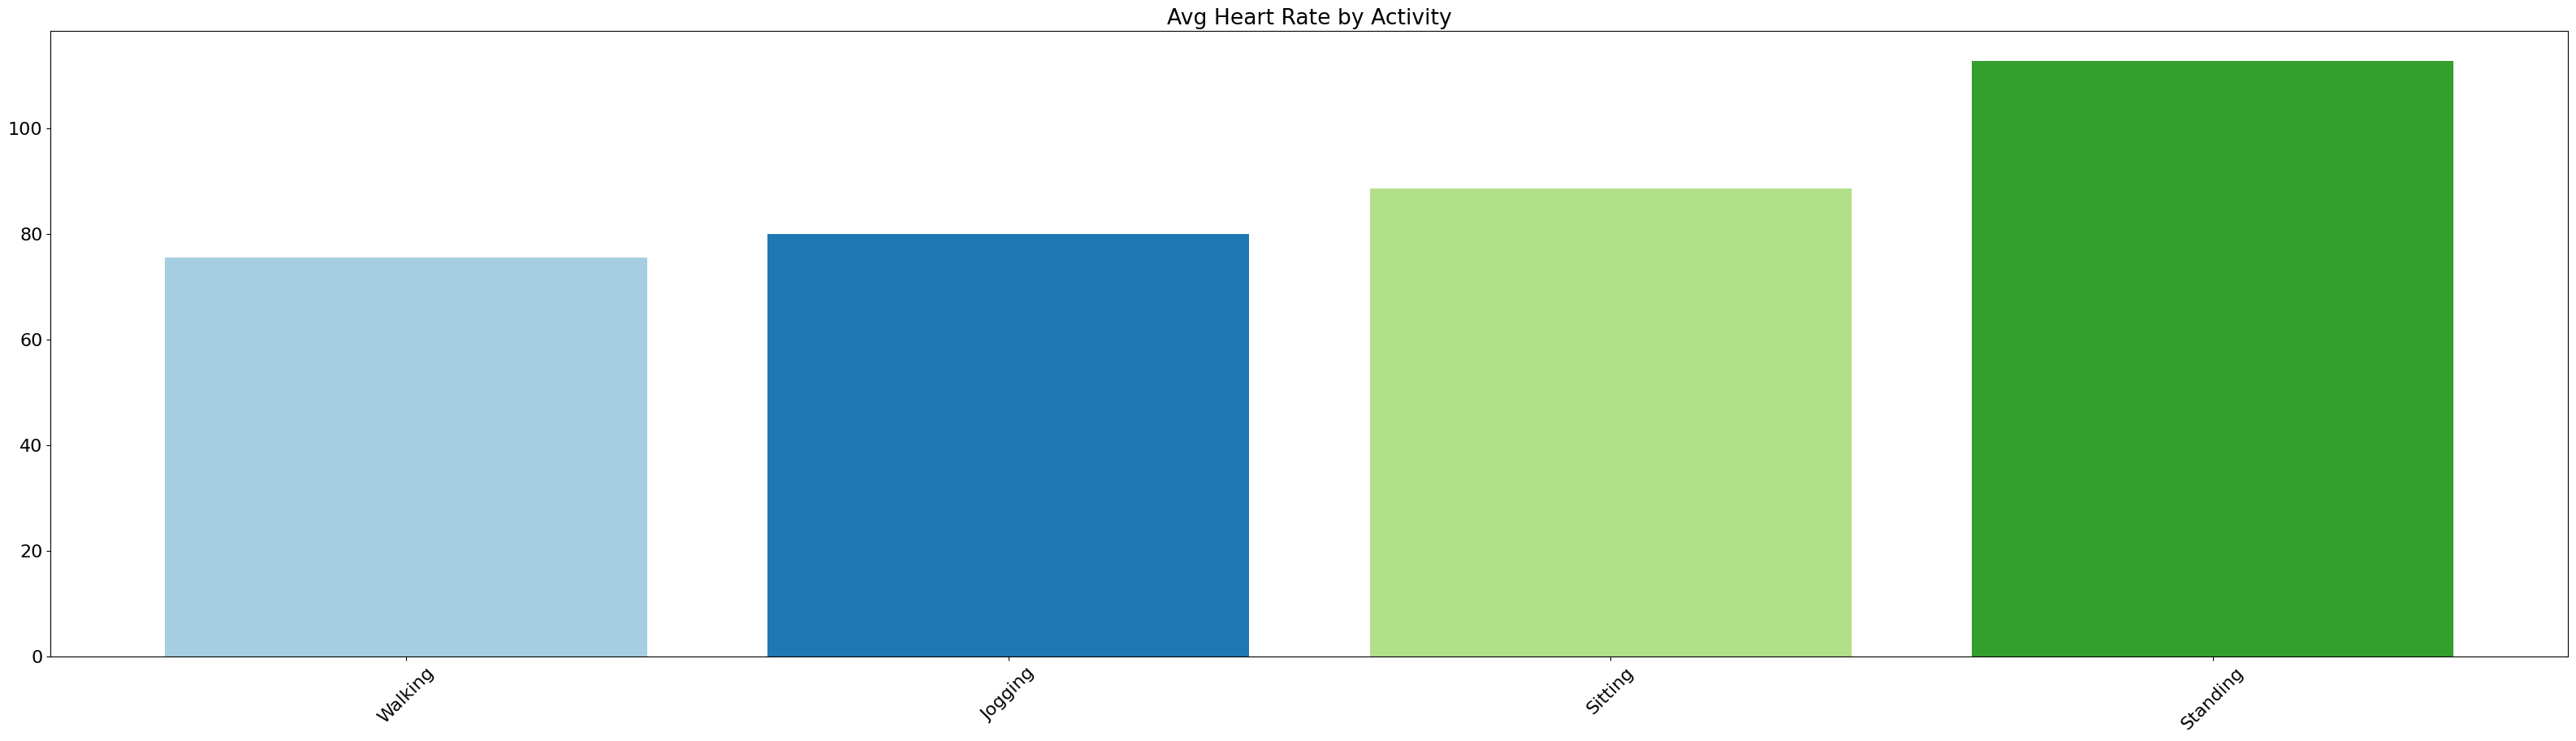

In [40]:

samples_heart_rate_activity = pd.DataFrame()
samples_heart_rate_activity['activity'] = [map_ac[x] for x in result_act['activity_id']]
samples_heart_rate_activity['heart_rate'] = result_act['heart_rate']
samples_heart_rate_activity = samples_heart_rate_activity.sort_values(by=['heart_rate'])
pd_fast_plot(samples_heart_rate_activity, 'heart_rate', 'activity', 'Avg Heart Rate by Activity', figsize=(40, 10))

Average temperatures by subjects

/var/folders/ww/qjh9zpks52d4vsjxc4bg379h0000gn/T/ipykernel_23005/3696987686.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(result_id['id'])


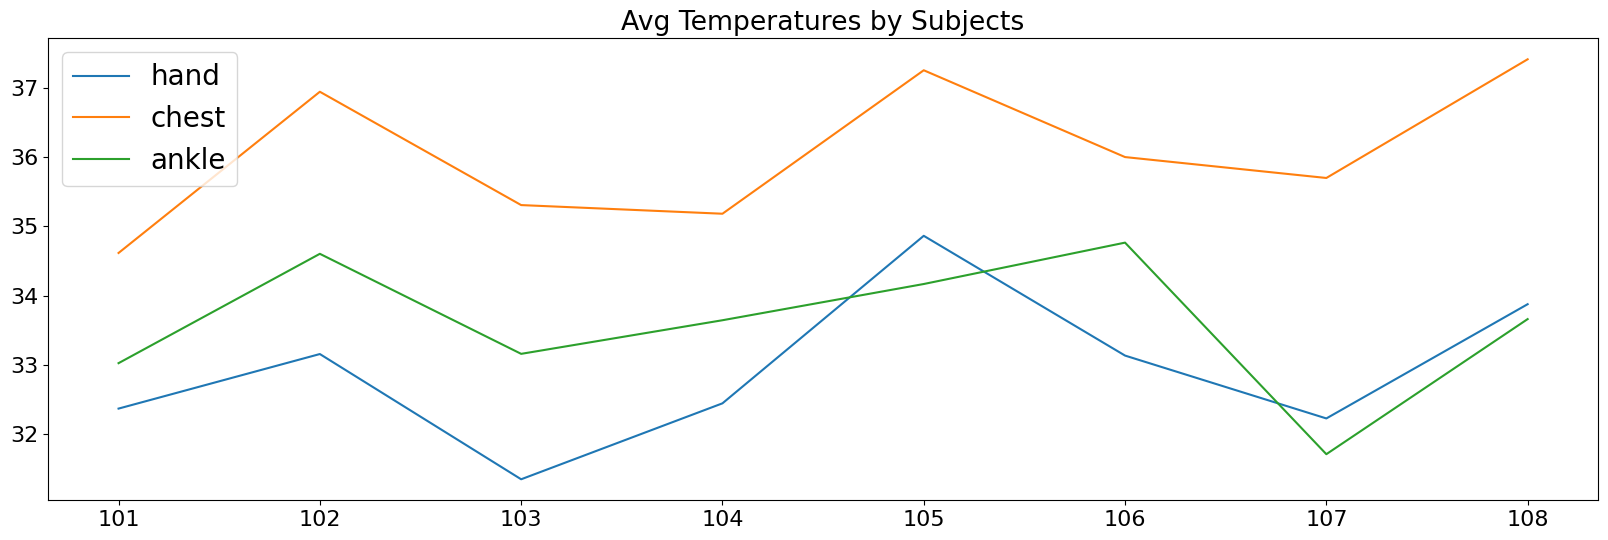

In [47]:

samples_temperature = pd.DataFrame()
samples_temperature['hand'] = result_id['hand_temperature']
samples_temperature['chest'] = result_id['chest_temperature']
samples_temperature['ankle'] = result_id['ankle_temperature']

ax = samples_temperature.plot(kind='line', figsize=(20, 6), title='Avg Temperatures by Subjects')
ax.set_xticklabels(result_id['id'])
ax.legend(fontsize=20)
ax.set_xticks(np.arange(len(samples_temperature)))

Average temperatures by activity

/var/folders/ww/qjh9zpks52d4vsjxc4bg379h0000gn/T/ipykernel_23005/1733493383.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(samples_temperature_activity['activity'])


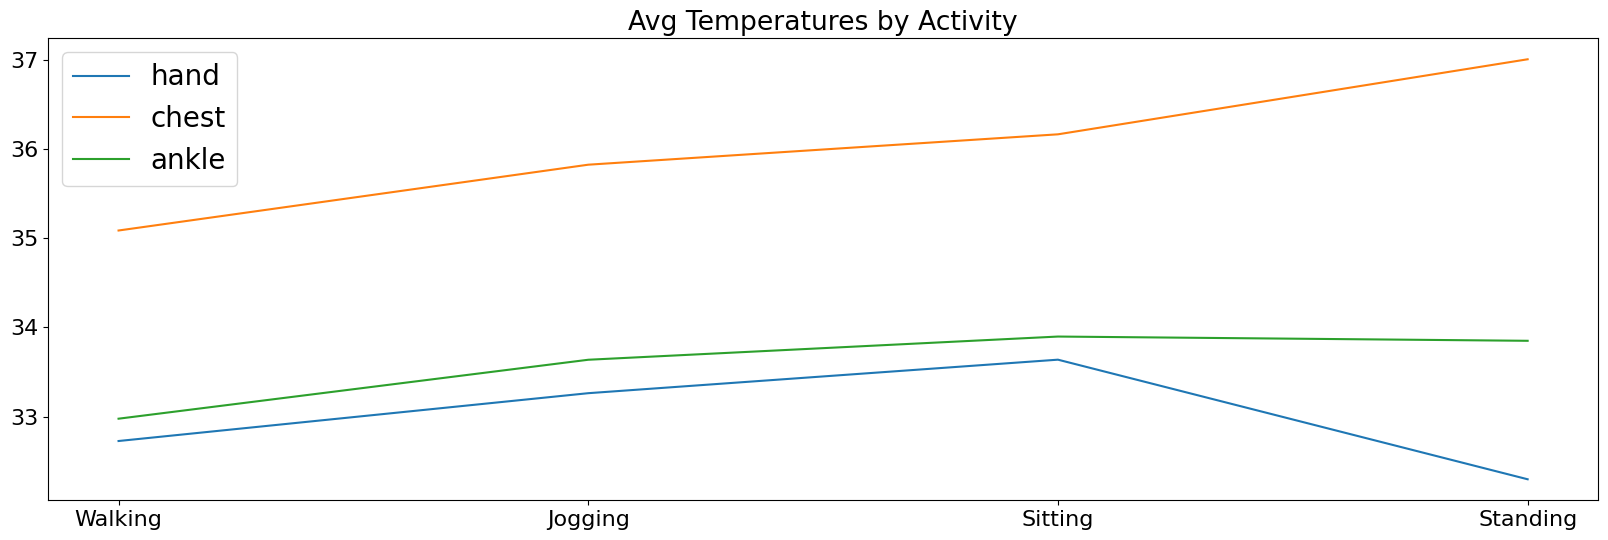

In [50]:

samples_temperature_activity = pd.DataFrame()
samples_temperature_activity['activity'] = [map_ac[x] for x in result_act['activity_id']]
samples_temperature_activity['hand'] = result_act['hand_temperature']
samples_temperature_activity['chest'] = result_act['chest_temperature']
samples_temperature_activity['ankle'] = result_act['ankle_temperature']

ax = samples_temperature_activity.plot(kind='line', figsize=(20, 6), title='Avg Temperatures by Activity')
ax.set_xticklabels(samples_temperature_activity['activity'])
ax.legend(fontsize=20)
ax.set_xticks(np.arange(len(samples_temperature_activity)))
plt.show()


Average hand acceleration values by subjects

/var/folders/ww/qjh9zpks52d4vsjxc4bg379h0000gn/T/ipykernel_23005/3270751834.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(result_id['id'])


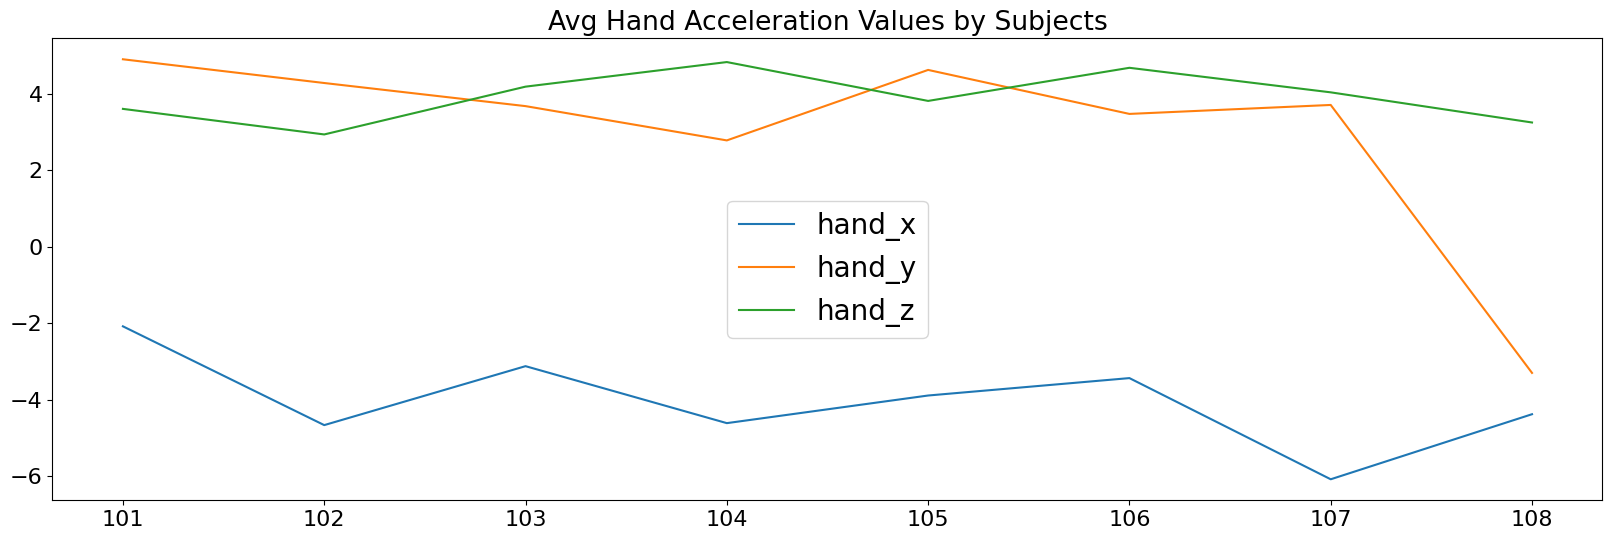

In [49]:

samples_hand_acceleration = pd.DataFrame()
samples_hand_acceleration['hand_x'] = result_id['hand_3D_acceleration_16_x']
samples_hand_acceleration['hand_y'] = result_id['hand_3D_acceleration_16_y']
samples_hand_acceleration['hand_z'] = result_id['hand_3D_acceleration_16_z']

ax = samples_hand_acceleration.plot(kind='line', figsize=(20, 6), title='Avg Hand Acceleration Values by Subjects')
ax.set_xticklabels(result_id['id'])
ax.legend(fontsize=20)
ax.set_xticks(np.arange(len(samples_hand_acceleration)))
plt.show()
